In [1669]:
import pandas as pd
import numpy as np
import os
import datetime
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [1670]:
# Load the dataset
df_o = pd.read_csv('./data/USvideos.csv', )
df = df_o.copy()

### Dataset Description ###  
This dataset contains stats on daily trending, U.S. based videos posted on YouTube. There are 40,949 records - each representing a trending video post. Video posts can be trending on multiple days, so the number of actual unique video post is 6,351. Each video post in the dataset contains 16 features, including: views, likes, dislikes, comment count, title, description, tags, publish date, trending date, etc. 

In [1671]:
#unique videos
df_o['video_id'].describe()['unique']

6351

### Variable Description

**1. Category ID:** The category of the video.  
**2. Views:** On average, the videos in this dataset received 2,360,784 views. The median received 681,861; while the max received 225,211,923. The outliers are driving the average higher.   
**3. Likes:** Likes variable share similar charecteristics as views.  
**4. Dislikes:** Dislikes variable share similar charecteristics as views.    
**5. Comment Count:** Comments variable share similar charecteristics as views.    

In [1672]:
print(df.describe().astype('int'))

       category_id      views    likes  dislikes  comment_count
count        40949      40949    40949     40949          40949
mean            19    2360784    74266      3711           8446
std              7    7394113   228885     29029          37430
min              1        549        0         0              0
25%             17     242329     5424       202            614
50%             24     681861    18091       631           1856
75%             25    1823157    55417      1938           5755
max             43  225211923  5613827   1674420        1361580


In [1673]:
# What are the column types?
# Descriptive stats of Comment Count, Likes and Dislikes are skewed as some videos have comments and/or reviews disabled. 
print(df.dtypes.sort_values())

comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
category_id                int64
views                      int64
                           ...  
channel_title             object
publish_time              object
tags                      object
thumbnail_link            object
description               object
Length: 16, dtype: object


### Variables Summary ###
Dataset seems to have large outliers that are driving these numbers out of wack.  
  
Descriptive stats for Comment Count, Likes and Dislikes are skewed as some videos have comments and/or reviews disabled. Additionally, there are dups in the dataset as videos can be trending on multiple days.
Normalizing the stats by eliminating those videos that have disabled ratings and comments, and consolidating dups, might make the dataset more useful.  

### What's the goal? ###  
**VIEWS** is the currency of YouTubers. The more views one gets, the more subscribers, followers and money they make. Our goal is to ask questions in relation to views.  

While the variables that the dataset provided seems useful, I'd like to know the video length to do analysis on views. I suspect that shorter videos receive more views, reviews and/or comments. If that is the case, then when we post videos on YT, our video length should be within that range that experiences more views.
  
In order to answer this question, we must reach out to YouTube - either by scraping the length of each video or accessing the YT API to get this data.  
  
Additionally, once we normalize the data and retrieve all the additional variables through scraping and feature engineering, we'll run a regression analysis to better understand the relationship and impact of the variables on video views.  

### Data Wrangling Plan & Questions ###  
**Tags:** How many tags does each video have? Does the more tags a video have garner more views, given its more discoverable? Does having an overwhelming amount of tag hurt you?  
  
**Description:** Does the length of the description help or hurt views?  
  
**Title:** Does the length of the title play a role in receiving more views? Do similar titles cannabalize views?  
  
**Channel Title:** Are there similar sounding channels? Maybe too many similar sounding channels cannabalize each others views?

**Publish and Trending Date:** On average, how long does it take for a video to go treding? What are the characteristics of the videos with the long lead time vs those with short lead time?  

### Formatting Dates for Conditionals ###  
Both variables need to be normalized as they are both in different formats.  
We will get the difference between trending and publish date. This will give us insight into, on average, how long do we have to wait for our video to go trending? Additionally, what is the relationship between trending lead time and the length of the video? Do shorter videos trend faster?  
  
Additionally, we will tease out the time it was published. For videos that trend on the same date it was published, the time it was published might give us an insight into when we should release our video to the public. I assume that prime time is the best time to publish.

In [1674]:
df[['publish_time', 'trending_date']][10:20]

,publish_time,trending_date
10,2017-11-13T02:05:26.000Z,17.14.11
11,2017-11-13T03:00:00.000Z,17.14.11
12,2017-11-13T17:00:00.000Z,17.14.11
13,2017-11-12T14:00:00.000Z,17.14.11
14,2017-11-12T18:30:01.000Z,17.14.11
15,2017-11-13T20:09:58.000Z,17.14.11
16,2017-11-12T17:00:05.000Z,17.14.11
17,2017-11-13T16:00:07.000Z,17.14.11
18,2017-11-13T15:30:17.000Z,17.14.11
19,2017-11-12T22:00:01.000Z,17.14.11


**Create singleton, lambda functions**

In [1675]:
getTime = lambda x: str(datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000Z').time())
getDate = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000Z').date()
getDateFormatted = lambda x: getDate(datetime.datetime(int(x[0:2]), int(x[6:8]), int(x[3:5])).strftime('20%y-%m-%dT%H:%M:%S.000Z'))
getDateDifference = lambda x: x.days

**Apply functions to Dataset to create new variables**

In [1676]:
df['publish_time_date'] = df['publish_time'].apply(getDate)
df['publish_time_time_use'] = df['publish_time'].apply(getTime)
df['trending_date_date'] = df['trending_date'].apply(getDateFormatted)
df['trend_lead_use'] = (df['trending_date_date'] - df['publish_time_date']).apply(getDateDifference)

### Dealing W/ Duplicate Videos ###  
There are approximately 6.3k unique videos in this dataset. Each video may be trending on multiple days, therefore - the stats provided are additive. View statistics for a video that is trending for 30 days are a running sum. 

**Dup Functions**  
getDups: Get how many "duplicate" rows does a certain video post have. The amount of "duplicate" rows it has signifies the amount of trending days.  
getFirstTrendStats: Get the date when the video first went trending. As well as the first trending day's views, likes, dislikes, comments


In [1677]:
getDups = lambda x: len(df[df['video_id'] == x])

def getFirstTrendStats(x):
    items = ['trending_date_date', 'views', 'likes', 'dislikes', 'comment_count']
    return [df[df['video_id'] == x['video_id']].sort_values(by=['trending_date_date'])[:1][i].values[0] for i in items]

**Get the amount of trending days**

In [1678]:
df['trending_days'] = df['video_id'].apply(getDups)

**Get the stats of the first trending day**

In [1679]:
cols = df.apply(getFirstTrendStats, axis=1, result_type='expand')
df['trending_date_first'] = cols[0]
df['views_first'] = cols[1]
df['likes_first'] = cols[2]
df['dislikes_first'] = cols[3]
df['comments_first'] = cols[4]

**Get all last trending day records. This will contain all unique video posts, without duplicates, which will hopefully be a more accurate dataset to work with.**

In [1680]:
df_u = pd.DataFrame(df['video_id'].unique(), columns=['video_id'])

In [1681]:
#& (df['trending_date_date'] == df[df['video_id'] == x['video_id']]['trending_date_date'].max())
df_use = df_u.apply(lambda x: df[(df['video_id'] == x['video_id']) & (df['trending_date_date'] == df[df['video_id'] == x['video_id']]['trending_date_date'].max())][:1].values[0], axis=1, result_type='expand')
df_use.columns = df.columns.tolist()
df_use.shape

(6351, 26)

In [1682]:
df = df_use

In [1683]:
df['trend_lead_use'] = (df['trending_date_first'] - df['publish_time_date']).apply(getDateDifference)
df['record'] = 1
df['views_mm'] = df['views'].apply(lambda x: x/1000000)

### Data Cleaning ###

**Tags**  
Tags look like they are seperated by the pipe symbol. Each tag after the first tag has quotes which should be scrubed.  
We'll create a column to seperate and count each tag, as well as count duplicate tags.

In [1684]:
df['tags'][10:20]

10    NFL|"Football"|"offense"|"defense"|"afc"|"nfc"...
11    The Walking Dead|"shiva"|"tiger"|"king ezekiel...
12    marshmello|"blocks"|"marshmello blocks"|"block...
13    nowthis|"nowthis world"|"world news"|"nowthis ...
14    shopping for new fish|"new fish"|"aquarium fis...
15    Robots|"Boston Dynamics"|"SpotMini"|"Legged Lo...
16    pacific rim|"pacific rim 2"|"pacific rim seque...
17    TED|"TED-Ed"|"TED Education"|"TED Ed"|"Hilary ...
18    ultralight|"airplane"|"homemade"|"DIY"|"hoverb...
19    SciShow|"science"|"Hank"|"Green"|"education"|"...
Name: tags, dtype: object

In [1685]:
# One time functions
cleanTags = lambda x: x.lower().replace('"','').split('|')
checkDups = lambda x: {i:cleanTags(x).count(i) for i in cleanTags(x)}

In [1686]:
# Generate additional tag fields
df['tags_clean'] = df['tags'].apply(cleanTags)
df['tags_count_use'] = df['tags'].apply(cleanTags).apply(len)
df['tags_dups'] = df['tags'].apply(checkDups)
df['tags_dups_count_use'] = df['tags_dups'].apply(dict.values).apply(max)

**Description**  
Very unscrutured. The only thing we can get from here is the length of the string.  
  
For additional analysis, we should see if the tags are present in the description. This will help us answer the question: are tags an addition to the description or should they contain duplicate terms.

In [1687]:
df['description_count_use'] = df['description'].apply(str).apply(lambda x: len(x))

**Title**   
Similar to Description, we should get the length of the title.  
  
For additional analysis, we should see if the tags are present in the title. If so, what position in the title does the tag take: beginning, middle, end? This will help us answer the question: are tags an addition to the title or should they contain duplicate terms. Also, this analysis could help us understand the importance of tags - do the search algorithm prioritize search results based on tag relevancy to the title?

In [1688]:
df['tile_count_use'] = df['title'].apply(str).apply(lambda x: len(x))

### Review New Variables ###
Off the bat, looking at the new variables, we can clearly see that the duplicate tags calculation we generate gives us no data: almost all video posts do not have duplicate tags. We will not be using this variable.  
  
Additionally, some outlier analysis must be done to the trend lead variable as 75% of the video posts in this dataset had at least a 9 day trend lead. However, there are some or one exception: a max of 4,215 trend lead. We should look into this/these video post(s) and discard or fix the result to be able to use this variable efficiently.

The rest of the other variables look decent enough to continuie working with.

In [1689]:
print(df.describe().astype('int'))

       category_id      views    likes  dislikes  comment_count  \
count         6351       6351     6351      6351           6351   
mean            20    1962117    55575      3067           6450   
std              7    7060057   193830     31988          33823   
min              1        559        0         0              0   
25%             17     159156     2772       127            372   
50%             24     518107    11906       444           1266   
75%             25    1473581    38428      1507           4061   
max             43  225211923  5613827   1674420        1361580   

       trend_lead_use  trending_days  views_first  likes_first  \
count            6351           6351         6351         6351   
mean               22              6       758209        34493   
std               209              4      1928993       116243   
min                -1              1          549            0   
25%                 1              3        83511         1908   


### Applying Categories ###

In [1690]:
file = open('./data/US_category_id.json')
categories = json.load(file)
file.close()

In [1691]:
#categories['items']

In [1692]:
cat_use = []

for item in categories['items']:
    x = {
        "id": int(item['id']),
        "name": item['snippet']['title']
    }
    cat_use.append(x)

In [1693]:
df = df.merge(pd.DataFrame(data=cat_use, columns=['id', 'name']), left_on='category_id', right_on='id' ,how='left')

In [1694]:
df['channel_title_count'] = df['channel_title'].apply(lambda x: len(df[df['channel_title'] == x]))

In [1695]:
p = lambda x: len(df[(df['channel_title'] == x['channel_title']) & (df['category_id'] == x['category_id']) ])
df['channel_title_count_p_cat'] = df.apply(
    p, 
    axis = 1,
    result_type='reduce'
)

### Features for Analysis ###

In [1696]:
#features = ['views', 'likes', 'dislikes', 'comment_count', 'tags_count_use', 'description_count_use','tile_count_use', 'trend_lead_use']
df_use = df

In [1697]:
df_wRatings = df_use[df_use['ratings_disabled']==True]
df_wComments = df_use[df_use['comments_disabled']==True]
df_use = df_use[(df_use['comments_disabled']==False) & (df_use['ratings_disabled']==False)]

### Views Feature ###  

**The dataset includes videos from different categories.**  
Obviously, some categories will receive more views than others. For example, the top viewed videos were in the music category. If we compare our videos to the whole dataset, we will be comparing apples and oranges and will be getting garbage results.

In [1698]:
def buildBarChart(groupby_x, y, layered=False, layered_y=None, title=None, sort=None):
    fig, ax = plt.subplots(figsize=(8,5))
    sns.set_color_codes("pastel")
    sns.barplot(x=y, 
                y=groupby_x, 
                data=df_use.groupby([groupby_x]).sum().reset_index(),
                label="Final Day", 
                color="r", 
                order=df_use.groupby([groupby_x]).sum().reset_index().sort_values(by=(sort if sort else y))[groupby_x]
               )
    if(title):
        ax.set(title=title)
    #Plot the crashes where alcohol was involved
    if(layered):
        sns.set_color_codes("muted")
        sns.barplot(x=groupby_x, y=layered_y, data=df_use.groupby([groupby_x]).sum().reset_index(),
                    label="First Day", color="b", order=df_use.groupby([groupby_x]).sum().reset_index().sort_values(by=(sort if sort else y))[groupby_x])

        # Add a legend and informative axis label
        ax.legend(ncol=2, loc="upper left", frameon=True)
    ax.set(ylabel=groupby_x, xlabel=y)
    plt.xticks(rotation=45)
    sns.despine(left=True, bottom=True)

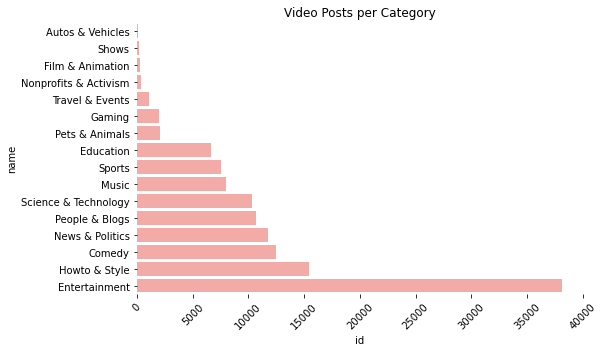

In [1699]:
buildBarChart('name', 'id', title='Video Posts per Category')
plt.savefig('Video Posts per Category.png', dpi=300, bbox_inches='tight')

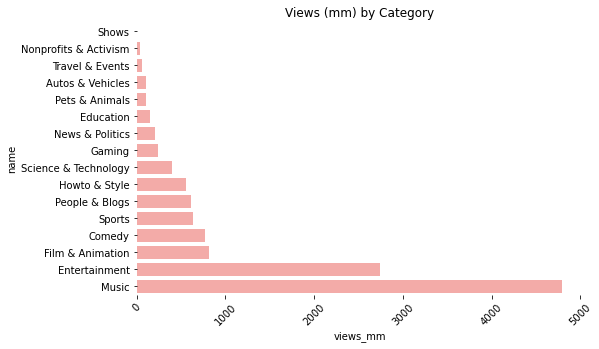

In [1700]:
buildBarChart('name', 'views_mm', title='Views (mm) by Category', sort='views')

We can see here the difference between aggregate view count per category. Music and Entertainment dominate the trending scene. This makes sense since musicians and entertainers, pressumably have a larger audience, bring their own fan base, which helps their view stats.  
  
Since we are not making entertainment nor music videos, it will be best to eliminate these 2 categories from our analysis as, we would be comparing apples to oranges.

For regression analysis, we'll add back the excluded categories and turn the category_id column into dummy variables.

In [1701]:
df_use = df_use[(df_use['category_id'] != 24) & (df_use['category_id'] != 10)]

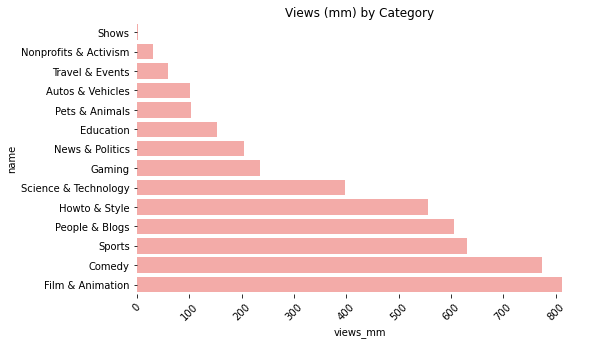

In [1702]:
buildBarChart('name', 'views_mm', title='Views (mm) by Category', sort='views_mm')

In [1703]:
df_agg = df_use.groupby(['category_id']).sum().reset_index()
df_agg['counts'] = df_use.groupby(['category_id']).size().reset_index(name='video_count')['video_count']
df_agg['channels'] = df_use.groupby(['category_id', 'channel_title']).size().reset_index(name='video_count').groupby(['category_id']).size().reset_index(name='channel_count')['channel_count']
df_agg = df_agg.merge(pd.DataFrame(data=cat_use, columns=['id', 'name']), left_on='category_id', right_on='id' ,how='left')
#df_agg['views_mm'] = df_agg['views'].apply(lambda x: x / 1000000)
df_agg['counts_to_channels'] = df_agg.apply(lambda x: x['counts'] / x['channels'], axis=1, result_type='expand')
df_agg[['category_id', 'counts', 'channels', 'counts_to_channels']]

,category_id,counts,channels,counts_to_channels
0,1,315,137,2.299270
1,2,69,56,1.232143
2,15,139,55,2.527273
3,17,443,126,3.515873
4,19,59,33,1.787879
...,...,...,...,...
9,26,593,189,3.137566
10,27,247,63,3.920635
11,28,368,158,2.329114
12,29,13,12,1.083333


In [1704]:
#13
def bubbleIt(x , y, labelx, labely, size='view'):
    
    if size == 'channel':
        sz = (df_agg['channels'] / df_agg['counts']) * 2500
    else:
        sz = (df_agg['views'] - df_agg['views_first'])/df_agg['views_first'] * 1000
        
    colors = [
        "#363732",
        "#F7C1BB",
        "#353A47",
        "#2A4849",
        "#885A5A",
        "#84B082",
        "#DC136C",
        "#222E50",
        "#53D8FB",
        "#D68C45",
        "#783F8E",
        "#4F1271"
    ]

    #bubble scatter plot
    #x: views
    #y: number of trending days
    #color of circles: category id
    #size of circle: count of video posts
    #Answers: If I were a YouTuber, what category will give me more bang for the buck?
    
    fig, ax = plt.subplots(figsize=(8,5))
    sns.scatterplot(
        data=df_agg, 
        x=x,
        y=y,
        s=sz,
        legend="full",
        #sizes=list(df_agg['trending_days']/df_agg['counts']),
        #sizes= (0,2500),
        hue = df_agg['name'] + " "+ df_agg['category_id'].apply(str),
        palette='rainbow_r'
    )
    ax.set(ylabel=labely,
           xlabel=labelx)

    for line in range(0, df_agg.shape[0]):
        plt.text(
             df_agg[x][line : line + 1],
             df_agg[y][line : line + 1],
             str(df_agg[line: line + 1]['category_id'].values[0]), 
             horizontalalignment='center', 
             verticalalignment='center_baseline', 
             size=12, 
             bbox=dict(facecolor='white', boxstyle='circle, pad=0.1'),
             color='black', 
             weight='bold'
        )

    plt.legend(bbox_to_anchor=(1.01, .95), loc=2, borderaxespad=0)
    plt.show()


**View Growth and Competition by Category**

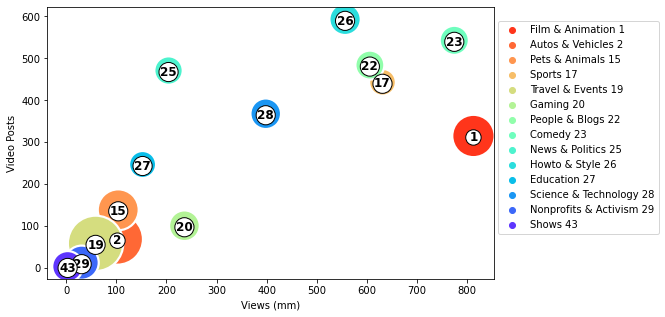

In [1705]:
bubbleIt('views_mm', 'counts', 'Views (mm)', 'Video Posts')

**The chart above plots each category along the amount of views and video posts they witnessed. The size of the circle indicates the growth in views between their trending lifespan.**   
    
What this chart help us see is the amount of competition per category and their respective trending viewership growth.  
  
Competition can be gleaned by the amount of video posts in that category. Typically, videos are competing for views within a certain category based on search term relevancy. Given a certain search term, the YouTube algo will recommend similar videos that fit that category.

On the one hand, the largest viewership growth appeared in videos posted under the "Travel & Events" category. This same category had less video posts as well. If we're starting a YouTube channel, the probability of us raising our viewership if we are trending seems strongest in the "Travel & Events" category, followed by "Autos & Vehicles" - given the low competition.

On the other hand, videos posted on the "How to & Style" witnessed modest viewership growth during their trending lifespan. A possible reason for this outcome is that there are a lot of videos posted, or competition, in this category. Pressumably, the amount of videos in this category might overload viewers with too many choices, thus driving them away. Especially if the videos are repeateable or similar content. One way to check if the latter statement is true is to do text analysis on the description and title of the videos - do they sound the same?

**A Closer Look at the Competition**  
  
While competition can be measured by how many videos are posted within a category, one must also look closely at the creators posting those videos. Some creators with outsized audiences may dominate views within a certain category because of their social lift. In this sense, the creator's channel can be thought of as the brand. Therefore, categories with viewership that is not distributed smoothly across channels may have lower probability of viwership growth.

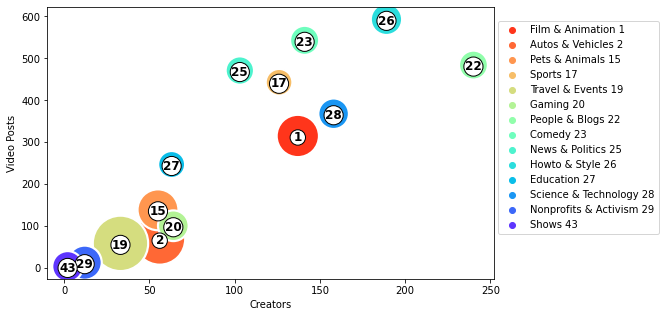

In [1706]:
bubbleIt('channels', 'counts', 'Creators', 'Video Posts')

The chart above is an attempt to tease out the stregth of channel branding per category. It plots the number of video posts and the amount of channels or "Creators" per category.  
  
This isn't enough to measure brand competition. We still don't know what the distribution of views within a category look like.

In [1707]:
x = df_use.groupby(['category_id', 'channel_title', 'views']).size().reset_index(name='video_count')
x['share'] = x.apply(lambda y: y['views'] / x[(x['category_id'] == y['category_id']) ]['views'].sum() * 100, axis=1)

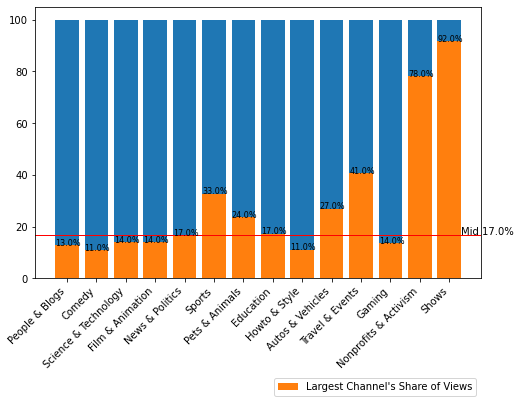

In [1708]:
#plt.bar(x['category_id'], x['share'].sum() - x['share'].max(), width=0.8)
fig, ax = plt.subplots(figsize=(8,5))
plt.bar( 
    np.arange(len([i for i in df_use['name'].unique()])),
    np.array([z[z['category_id'] == i][['share']].sum().values[0] for i in df_use['category_id'].unique()]), 
    width=0.8, 
    tick_label=[i for i in df_use['name'].unique()],
    linewidth=1,
)     
plt.bar(
    np.arange(len([i for i in df_use['name'].unique()])),
    [z[z['category_id'] == i][['share']].max().values[0] for i in df_use['category_id'].unique()], 
    width=0.8,
    label="Largest Channel's Share of Views"
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
ax.axhline(
    np.median([z[z['category_id'] == i][['share']].max().values[0] for i in df_use['category_id'].unique()]), 
    color='red', 
    linewidth=1
)
ax.annotate(
'Mid' + " " + str(np.round(np.median([z[z['category_id'] == i][['share']].max().values[0] for i in df_use['category_id'].unique()]))) + "%", 
    (13.4,np.median([z[z['category_id'] == i][['share']].max().values[0] for i in df_use['category_id'].unique()])),
    color='black'
)
counter = 0.0
for num in [z[z['category_id'] == i][['share']].max().values[0] for i in df_use['category_id'].unique()]:
    ax.annotate(
    str(np.round(num)) + "%", 
        (counter - 0.40, num),
        color='black',
        fontsize=8.0
    )
    counter+=1
    
plt.legend(loc='lower right', bbox_to_anchor=(1,-0.45))
plt.show()



The chart above can help us look at viewership amongsts the channels within a category. It plots the largest channel's share of total views per category. For example, within the "Sports" category, one channel took home 33% of all views.  
  
**Why does this matter?**  
  
As mentioned above, if we're starting out as YouTube creators, we have to look for pockets or areas where there wont be as much competition for search results, views and thus trending opportunities for our content. Posting content within a certain category that is dominated by a/or certain channel(s) might render our video post noncompetative.  
  
In the end, user's search results begin with content from channels they're subscribed to; similar channels to those subscribed, and finally similar content.  
  
The results above contradict my earlier assertions on competition. In fact, we might want to steer clear of the "Travel & Events" and "Automobile" categories since, relative to the other categories, these two categories' distribution of views are skewed given the precense of high channel recognition.

In contrast, the "How to & Style" category has the least amount of channel dominitation.


**Strategy to Move Forward**  
  
Armed with these bits of information, we could go two routes:  
  
1. Copy-Cat Strategy: Post content to the category with least video posts.  
2. Diffirentiation Strategy: Post content to the category with least channel recognition.  

The former option would have us competiting against possible established channels with a large audience. However, that just means we have to do all we can to be "similar" to that large branded channel. To slowly chip away at their viewership by posting comments and attracting their viewers into our videos. Categories with the least posts, while in the presence of large channels, give us examples on who to become.

The latter option, would lower the playing field but we have to overcompete to ensure our content is at the top of the search results. This means, video posts in these categories need to be constantly optimized for the search engine: our title, keywords, tags, decription and thumbnail will play a major role in trying to differentiate ourselves from the rest of the content in this category.  

In [27]:
def getCorrHeatmap():
    corr = df_use.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );